# Task 4 — Geometric Transformations

In [23]:
import os
import numpy as np
import cv2
from skimage import io, img_as_ubyte
import matplotlib.pyplot as plt

# ======== CONFIG ========

In [24]:
IMG_PATH = "../img/car.jpg" 
OUT_DIR  = "task4_outputs"
BORDER   = cv2.BORDER_REFLECT 
SAVE_OUTPUTS = True

os.makedirs(OUT_DIR, exist_ok=True)

def save_rgb(bgr, title, name):
    plt.figure()
    plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    plt.title(title); plt.axis("off")
    plt.savefig(os.path.join(OUT_DIR, name), bbox_inches="tight", pad_inches=0)
    plt.close()

# --- Load to BGR uint8 for OpenCV ---

In [25]:
im = io.imread(IMG_PATH)
if im.ndim == 2:
    im = np.repeat(im[..., None], 3, axis=2)
im_bgr = cv2.cvtColor(img_as_ubyte(im[..., :3]), cv2.COLOR_RGB2BGR)
H, W = im_bgr.shape[:2]
cx, cy = W/2, H/2

# ---------- Affine (2x3) ----------

In [26]:
# 1) Translation
tx, ty = 60, -40
M_t = np.array([[1, 0, tx],
                [0, 1, ty]], dtype=np.float32)
im_t = cv2.warpAffine(im_bgr, M_t, (W, H), flags=cv2.INTER_LINEAR, borderMode=BORDER)
save_rgb(im_t, f"Translation (tx={tx}, ty={ty})", "01_translation.png")

# 2) Rotation about center
angle, scale = 25, 1.0
M_r = cv2.getRotationMatrix2D((cx, cy), angle, scale)  # 2x3
im_r = cv2.warpAffine(im_bgr, M_r, (W, H), flags=cv2.INTER_LINEAR, borderMode=BORDER)
save_rgb(im_r, f"Rotation {angle}° about center", "02_rotation.png")

# 3) Scaling
# (a) about center
sx, sy = 0.7, 0.7
M_s_center = np.array([[sx, 0,  cx*(1 - sx)],
                       [0,  sy, cy*(1 - sy)]], dtype=np.float32)
im_s_center = cv2.warpAffine(im_bgr, M_s_center, (W, H), flags=cv2.INTER_LINEAR, borderMode=BORDER)
save_rgb(im_s_center, f"Scaling about center (sx={sx}, sy={sy})", "03_scaling_center.png")

# (b) about origin (top-left) + expand canvas
sx2, sy2 = 1.2, 0.8
M_s_origin = np.array([[sx2, 0,   0],
                       [0,   sy2, 0]], dtype=np.float32)
out_wh = (int(W*sx2), int(H*sy2))
im_s_origin = cv2.warpAffine(im_bgr, M_s_origin, out_wh, flags=cv2.INTER_LINEAR, borderMode=BORDER)
save_rgb(im_s_origin, f"Scaling about origin (sx={sx2}, sy={sy2})", "04_scaling_origin.png")

# 4) Compose affine: rotate then translate (homogeneous multiply)
def affine2x3_to_3x3(M):
    H3 = np.eye(3, dtype=np.float32); H3[:2, :] = M
    return H3
M_rt_3 = affine2x3_to_3x3(M_t) @ affine2x3_to_3x3(M_r)  # T ∘ R_center
M_rt = M_rt_3[:2, :]
im_rt = cv2.warpAffine(im_bgr, M_rt, (W, H), flags=cv2.INTER_LINEAR, borderMode=BORDER)
save_rgb(im_rt, "Rotate (center) then Translate", "05_rotate_then_translate.png")

# ---------- Perspective (3x3 homography) ----------

In [27]:
# Source corners TL, TR, BR, BL
src = np.float32([[0,0], [W-1,0], [W-1,H-1], [0,H-1]])

# Destination quad (you can edit these to your liking)
dst = np.float32([[0.12*W, 0.05*H],
                  [0.88*W, 0.02*H],
                  [0.78*W, 0.95*H],
                  [0.22*W, 1.00*H]])

H_p = cv2.getPerspectiveTransform(src, dst)  # 3x3
im_p = cv2.warpPerspective(im_bgr, H_p, (W, H), flags=cv2.INTER_LINEAR, borderMode=BORDER)
save_rgb(im_p, "Perspective Warp (keystone)", "06_perspective.png")

# Inverse check
H_inv = np.linalg.inv(H_p)
im_back = cv2.warpPerspective(im_p, H_inv, (W, H), flags=cv2.INTER_LINEAR, borderMode=BORDER)
save_rgb(im_back, "Inverse Perspective (approx original)", "07_perspective_inverse.png")


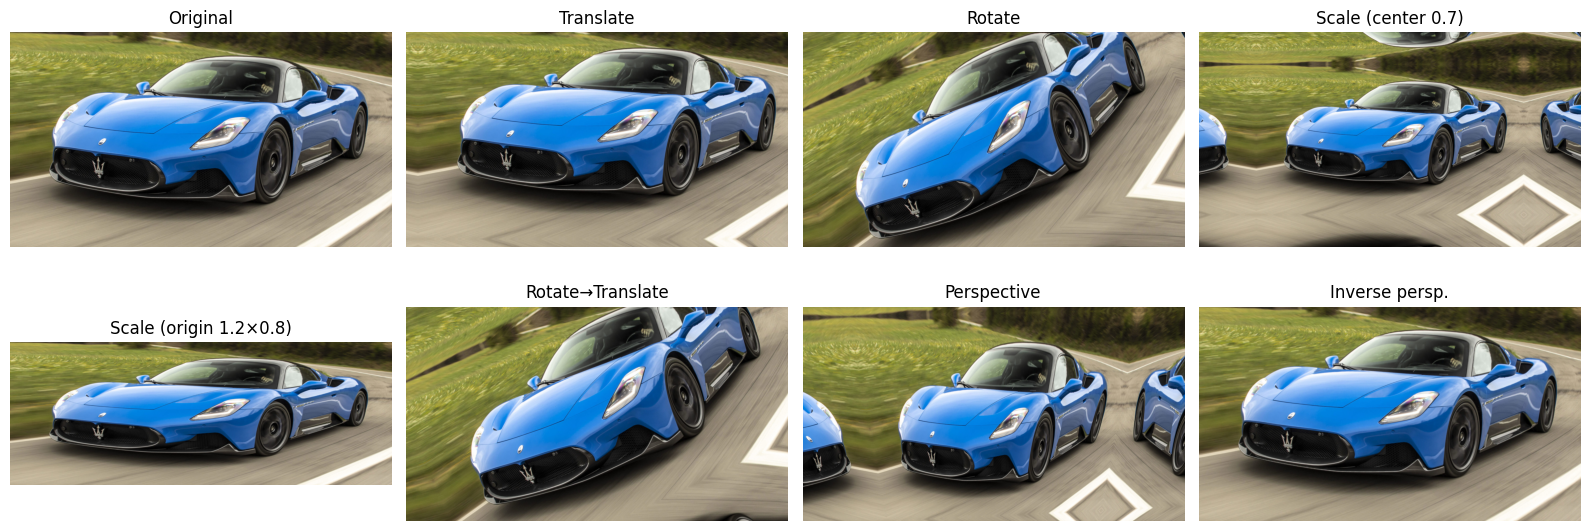

In [22]:
# ---- Summary panel: original + all transforms ----
titles_imgs = [
    ("Original", im_bgr),
    ("Translate", im_t),
    ("Rotate", im_r),
    ("Scale (center 0.7)", im_s_center),
    ("Scale (origin 1.2×0.8)", im_s_origin),
    ("Rotate→Translate", im_rt),
    ("Perspective", im_p),
    ("Inverse persp.", im_back),
]

cols = 4
rows = int(np.ceil(len(titles_imgs) / cols))
fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))

# Flatten axes for easy zip; handle last empty cells
axs = axs.ravel() if hasattr(axs, "ravel") else [axs]
for ax, (t, imv) in zip(axs, titles_imgs):
    ax.imshow(cv2.cvtColor(imv, cv2.COLOR_BGR2RGB))
    ax.set_title(t)
    ax.axis('off')
for ax in axs[len(titles_imgs):]:
    ax.axis('off')

plt.tight_layout()
if SAVE_OUTPUTS:
    plt.savefig(os.path.join(OUT_DIR, "transforms_panel.png"), dpi=200)
plt.show()


# ---------- Print matrices for your report ----------

In [28]:
np.set_printoptions(precision=3, suppress=True)
print("\nTranslation M_t (2x3):\n", M_t)
print("\nRotation (center) M_r (2x3):\n", M_r)
print("\nScaling about center M_s_center (2x3):\n", M_s_center)
print("\nScaling about origin M_s_origin (2x3):\n", M_s_origin)
print("\nComposed Affine M_rt = T ∘ R (2x3):\n", M_rt)
print("\nPerspective H_p (3x3):\n", H_p)


Translation M_t (2x3):
 [[  1.   0.  60.]
 [  0.   1. -40.]]

Rotation (center) M_r (2x3):
 [[   0.906    0.423 -138.269]
 [  -0.423    0.906  456.307]]

Scaling about center M_s_center (2x3):
 [[  0.7   0.  288. ]
 [  0.    0.7 162. ]]

Scaling about origin M_s_origin (2x3):
 [[1.2 0.  0. ]
 [0.  0.8 0. ]]

Composed Affine M_rt = T ∘ R (2x3):
 [[  0.906   0.423 -78.269]
 [ -0.423   0.906 416.307]]

Perspective H_p (3x3):
 [[  0.797   0.321 230.4  ]
 [ -0.016   1.316  54.   ]
 [  0.      0.      1.   ]]


# Explanation for Report

### Goal
Explore and visualize **affine** and **perspective** transformations using OpenCV functions.

---

### Theory
Geometric transformations change the spatial relationship between pixels by applying a matrix to their coordinates.

An **affine transformation** is represented by a 2×3 matrix:
\[
\begin{bmatrix}
a_{11} & a_{12} & t_x \\
a_{21} & a_{22} & t_y
\end{bmatrix}
\]
The first two columns define linear effects (rotation, scaling, or shear), and the last column defines translation.  
Affine transforms keep straight lines straight and preserve parallelism, but can change distances and angles.

A **perspective (projective) transformation** uses a 3×3 matrix:
\[
\begin{bmatrix}
h_{11} & h_{12} & h_{13} \\
h_{21} & h_{22} & h_{23} \\
h_{31} & h_{32} & 1
\end{bmatrix}
\]
It maps homogeneous coordinates \((x, y, 1)\) → \((x', y', w')\) with \(x' = X/W\) and \(y' = Y/W\),  
producing realistic 3D effects like convergence and foreshortening.  
Unlike affine transforms, perspective transformations do **not** preserve parallelism but still keep straight lines as straight.

---

### Implemented Transformations
1. **Translation** — shifts the image by `(tx, ty)`.  
2. **Rotation** — rotates around a chosen center point (here, the image center).  
3. **Scaling** — resizes the image uniformly or non-uniformly, optionally around a center.  
4. **Affine Composition** — combines multiple transformations (e.g., rotate then translate).  
5. **Perspective Warp** — maps four corner points to arbitrary quadrilateral points (keystone effect).  
6. **Inverse Perspective** — restores the warped image using the inverse homography.

---

### Explanation
Each transformation changes geometry based on its matrix:

- **Translation** adds offset \((t_x, t_y)\).  
- **Rotation** multiplies coordinates by a rotation matrix around the image center.  
- **Scaling** multiplies distances by scale factors \((s_x, s_y)\).  
- **Perspective warp** divides coordinates by a depth factor, creating 3D-like distortion.  

Affine matrices preserve straight and parallel lines, while perspective matrices preserve straightness but not parallelism.  
Together, they define how images are repositioned, rotated, scaled, or warped in computer vision.

---

**Expected Output:**  
- `01_translation.png` – translated image  
- `02_rotation.png` – rotated image  
- `03_scaling_center.png` – scaled about center  
- `04_scaling_origin.png` – scaled about origin  
- `05_rotate_then_translate.png` – composed affine  
- `06_perspective.png` – perspective warp  
- `07_perspective_inverse.png` – inverse warp check
